# Libraries

In [1]:
import gc
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint

# 🚫 Suppressing warnings 🚫
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

In [3]:
from scipy.stats import entropy
from collections import Counter
import polars as pl

In [4]:
from joblib import Parallel, delayed
from time import sleep, time
from multiprocessing import cpu_count

In [5]:
from tqdm.auto import tqdm 

# Reading train_series parquet

In [62]:
%%time
# inspired by https://www.kaggle.com/code/enricomanosperti/detect-sleep-states-first-preprocessing-and-eda
import polars as pl
train_series = (pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.strftime('%Y-%m-%d').alias("year_month_day")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: user 2min 50s, sys: 53.9 s, total: 3min 44s
Wall time: 2min 40s


In [7]:
len(train_series)

127946340

In [8]:
df=train_series.groupby('series_id').size()
df

series_id
038441c925bb    389880
03d92c9f6f8a    724140
0402a003dae9    397260
04f547b8017d    637560
05e1944c3818    400860
                 ...  
fa149c3c4bde    406800
fb223ed2278c    918360
fbf33b1a2c10    421020
fcca183903b7    620640
fe90110788d2    592380
Length: 277, dtype: int64

In [9]:
train_series.head(5)

,series_id,step,timestamp,anglez,enmo,year,month,day,hour,year_month_day
0,038441c925bb,0,2018-08-14 15:30:00,2.6367,0.0217,2018,8,14,15,2018-08-14
1,038441c925bb,1,2018-08-14 15:30:05,2.6368,0.0215,2018,8,14,15,2018-08-14
2,038441c925bb,2,2018-08-14 15:30:10,2.6370,0.0216,2018,8,14,15,2018-08-14
3,038441c925bb,3,2018-08-14 15:30:15,2.6368,0.0213,2018,8,14,15,2018-08-14
4,038441c925bb,4,2018-08-14 15:30:20,2.6368,0.0215,2018,8,14,15,2018-08-14


In [63]:
df=train_series.groupby('series_id').year_month_day.nunique()
df

series_id
038441c925bb    24
03d92c9f6f8a    43
0402a003dae9    24
04f547b8017d    38
05e1944c3818    24
                ..
fa149c3c4bde    25
fb223ed2278c    54
fbf33b1a2c10    26
fcca183903b7    37
fe90110788d2    36
Name: year_month_day, Length: 277, dtype: int64

In [64]:
df=df.reset_index()

In [13]:
import seaborn as sns

In [19]:
df.columns

Index(['series_id', 'year_month_day'], dtype='object')

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,4))
ax = sns.displot(df,x="year_month_day",alpha = .4,color="#9b59b6",bins=15, linewidth = 0)
#ax.bar_label(ax.containers[1], fmt='%.0f',color="#F2A5A5",fontweight='bold')
plt.xlabel("Number of nights", fontsize=12)
plt.ylabel("Number of individuals", fontsize=12)
plt.legend(loc='upper right')
plt.show()


<Figure size 800x400 with 0 Axes>

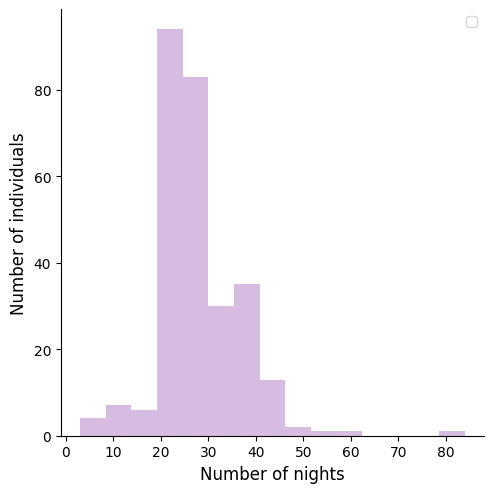

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,4))
ax = sns.displot(df,x="year_month_day",alpha = .4,color="#84B29E",bins=15, linewidth = 0)
#ax.bar_label(ax.containers[1], fmt='%.0f',color="#F2A5A5",fontweight='bold')
plt.xlabel("Number of nights", fontsize=12)
plt.ylabel("Number of individuals", fontsize=12)
plt.legend(loc='upper right')
plt.show()


# Reading the merge train events and train series

In [204]:
%%time
train_series_events  = pd.read_parquet('/kaggle/input/gamma-train-series-updated-11-11-2023/train_series_10112023.parquet')
len(train_series_events)

CPU times: user 23.5 s, sys: 24.1 s, total: 47.7 s
Wall time: 20.4 s


84936878

In [205]:
train_series_events=train_series_events[(train_series_events['event_2']!='Other')]
len(train_series_events)

9583

In [206]:
train_series_events.columns

Index(['row_id', 'series_id', 'step', 'timestamp', 'anglez', 'enmo', 'hour',
       'event', 'event_2', 'night'],
      dtype='object')

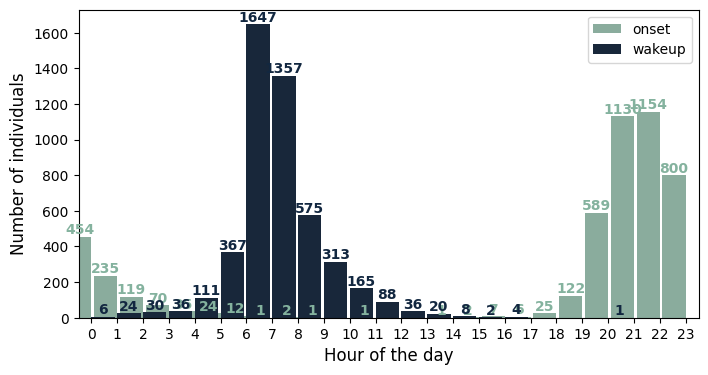

In [212]:
train_series_events['series_id_night']=train_series_events['series_id'].astype(str)+'_'+train_series_events['night'].astype(str)
df=train_series_events.groupby(['hour','event']).series_id_night.nunique()
df=df.reset_index()
df=df.fillna(method='ffill')
df['hour']=df['hour'].astype(int)

import matplotlib.pyplot as plt

fig = plt. figure(figsize=(8,4))
ax = sns.barplot(df,x="hour",y="series_id_night",hue="event", width=1.8,alpha = 1,palette=["#84B29E", "#122740"])
ax.bar_label(ax.containers[0], fmt='%.0f',color="#84B29E",fontweight='bold')
ax.bar_label(ax.containers[1], fmt='%.0f',color="#122740",fontweight='bold')
#ax.bar_label(ax.containers[0], fmt='%.0f',color="#9b59b6",fontweight='bold')
#ax.bar_label(ax.containers[1], fmt='%.0f',color="#F2A5A5",fontweight='bold')
plt.xlabel("Hour of the day", fontsize=12)
plt.ylabel("Number of individuals", fontsize=12)
plt.legend(loc='upper right')
plt.show()


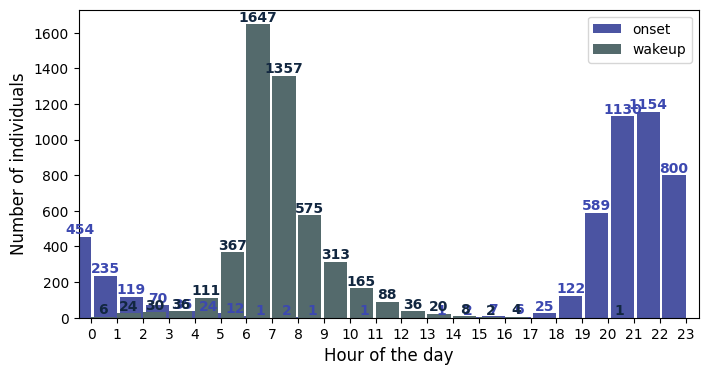

In [234]:
train_series_events['series_id_night']=train_series_events['series_id'].astype(str)+'_'+train_series_events['night'].astype(str)
df=train_series_events.groupby(['hour','event']).series_id_night.nunique()
df=df.reset_index()
df=df.fillna(method='ffill')
df['hour']=df['hour'].astype(int)

import matplotlib.pyplot as plt

fig = plt. figure(figsize=(8,4))
ax = sns.barplot(df,x="hour",y="series_id_night",hue="event", width=1.8,alpha = 1,palette=["#3C48B0", "#506E70"])
ax.bar_label(ax.containers[0], fmt='%.0f',color="#3C48B0",fontweight='bold')
ax.bar_label(ax.containers[1], fmt='%.0f',color="#122740",fontweight='bold')
#ax.bar_label(ax.containers[0], fmt='%.0f',color="#9b59b6",fontweight='bold')
#ax.bar_label(ax.containers[1], fmt='%.0f',color="#F2A5A5",fontweight='bold')
plt.xlabel("Hour of the day", fontsize=12)
plt.ylabel("Number of individuals", fontsize=12)
plt.legend(loc='upper right')
plt.show()

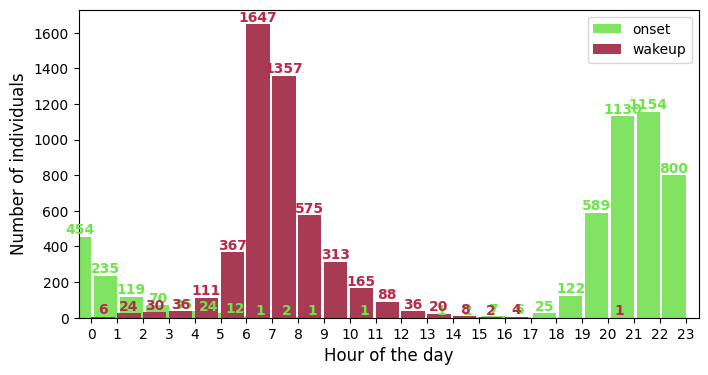

In [239]:
train_series_events['series_id_night']=train_series_events['series_id'].astype(str)+'_'+train_series_events['night'].astype(str)
df=train_series_events.groupby(['hour','event']).series_id_night.nunique()
df=df.reset_index()
df=df.fillna(method='ffill')
df['hour']=df['hour'].astype(int)

import matplotlib.pyplot as plt

fig = plt. figure(figsize=(8,4))
ax = sns.barplot(df,x="hour",y="series_id_night",hue="event", width=1.8,alpha = 1,palette=["#75F94D", "#BA2949"])
#ax.bar_label(ax.containers[0], fmt='%.0f',color="#84B29E",fontweight='bold')
#ax.bar_label(ax.containers[1], fmt='%.0f',color="#122740",fontweight='bold')
ax.bar_label(ax.containers[0], fmt='%.0f',color="#6CE647",fontweight='bold')
ax.bar_label(ax.containers[1], fmt='%.0f',color="#BA2949",fontweight='bold')
plt.xlabel("Hour of the day", fontsize=12)
plt.ylabel("Number of individuals", fontsize=12)
plt.legend(loc='upper right')
plt.show()

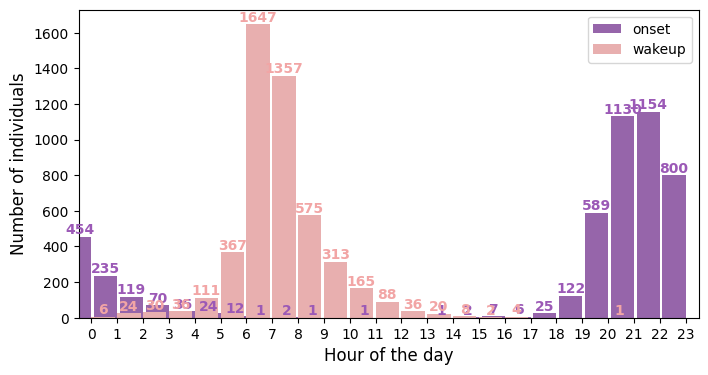

In [222]:
train_series_events['series_id_night']=train_series_events['series_id'].astype(str)+'_'+train_series_events['night'].astype(str)
df=train_series_events.groupby(['hour','event']).series_id_night.nunique()
df=df.reset_index()
df=df.fillna(method='ffill')
df['hour']=df['hour'].astype(int)

import matplotlib.pyplot as plt

fig = plt. figure(figsize=(8,4))
ax = sns.barplot(df,x="hour",y="series_id_night",hue="event", width=1.8,alpha = 1,palette=["#9b59b6", "#F2A5A5"])
#ax.bar_label(ax.containers[0], fmt='%.0f',color="#84B29E",fontweight='bold')
#ax.bar_label(ax.containers[1], fmt='%.0f',color="#122740",fontweight='bold')
ax.bar_label(ax.containers[0], fmt='%.0f',color="#9b59b6",fontweight='bold')
ax.bar_label(ax.containers[1], fmt='%.0f',color="#F2A5A5",fontweight='bold')
plt.xlabel("Hour of the day", fontsize=12)
plt.ylabel("Number of individuals", fontsize=12)
plt.legend(loc='upper right')
plt.show()


In [106]:
%%time

idx='2fbbee1a38e3'
df  = pd.read_parquet('/kaggle/input/gamma-train-series-updated-11-11-2023/train_series_10112023.parquet',
                                      filters=[('series_id','=',idx)])
len(df)

CPU times: user 14.2 s, sys: 7.9 s, total: 22.1 s
Wall time: 7.43 s


374801

In [107]:
df['date_time'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
df['event_wakeup'] = np.where(df['event_2']=='wakeup',1,0)
df['event_onset'] = np.where(df['event_2']=='onset',1,0)
a=df[(df['event_wakeup']>0)]['timestamp'].iloc[:]
b=df[(df['event_onset']>0)]['timestamp'].iloc[:]
a

12852    2017-09-01 06:21:00
31092    2017-09-02 07:41:00
48192    2017-09-03 07:26:00
65976    2017-09-04 08:08:00
82704    2017-09-05 07:22:00
100572   2017-09-06 08:11:00
117708   2017-09-07 07:59:00
135048   2017-09-08 08:04:00
152184   2017-09-09 07:52:00
169512   2017-09-10 07:56:00
187416   2017-09-11 08:48:00
204108   2017-09-12 07:59:00
221364   2017-09-13 07:57:00
237912   2017-09-14 06:56:00
255372   2017-09-15 07:11:00
272604   2017-09-16 07:07:00
290244   2017-09-17 07:37:00
310625   2017-09-19 06:52:00
328169   2017-09-20 07:14:00
345233   2017-09-21 06:56:00
362681   2017-09-22 07:10:00
Name: timestamp, dtype: datetime64[ns]

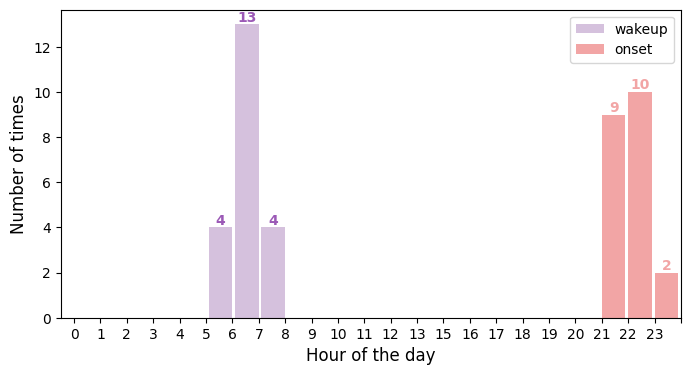

In [120]:
df['series_id_night']=df['series_id'].astype(str)+'_'+df['night'].astype(str)
df2=df[(df['event_2']!='Other')]
df2=df2.groupby(['hour','event']).series_id_night.nunique()
df2=df2.reset_index()
df2=df2.fillna(method='ffill')
df2['hour']=df2['hour'].astype(int)

df3=pd.DataFrame({'hour':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,15,16,17,18,19,20,21,22,23,
                         0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,15,16,17,18,19,20,21,22,23], 'event':['wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup','wakeup',
                                                                        'onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset','onset',]})
df3=df3.merge(df2,how="left",on=['hour','event'])
#df3=df3.fillna(0)

import matplotlib.pyplot as plt

fig = plt. figure(figsize=(8,4))
ax = sns.barplot(df3,x="hour",y="series_id_night",hue="event", width=1.8,alpha = .4,palette=["#9b59b6", "#ff0000"])
ax.bar_label(ax.containers[0], fmt='%.0f',color="#9b59b6",fontweight='bold')
ax.bar_label(ax.containers[1], fmt='%.0f',color="#F2A5A5",fontweight='bold')
ax.set_xticks(np.arange(0, 24, 1))
plt.xlabel("Hour of the day", fontsize=12)
plt.ylabel("Number of times", fontsize=12)
plt.legend(loc='upper right')
plt.show()

In [123]:
df4=df[(df['night']==1)]
a=df4[(df4['event_wakeup']>0)]['timestamp'].iloc[:]
b=df4[(df4['event_onset']>0)]['timestamp'].iloc[:]
a

12852   2017-09-01 06:21:00
Name: timestamp, dtype: datetime64[ns]

In [146]:
df4['anglez_norm'] = (df4['anglez']-np.min(df4['anglez']))/ (max(df4['anglez'])-min(df4['anglez']))
df4['enmo_norm'] = (df4['enmo']-np.min(df4['enmo']))/ (max(df4['enmo'])-min(df4['enmo']))


In [138]:
from datetime import datetime, timedelta

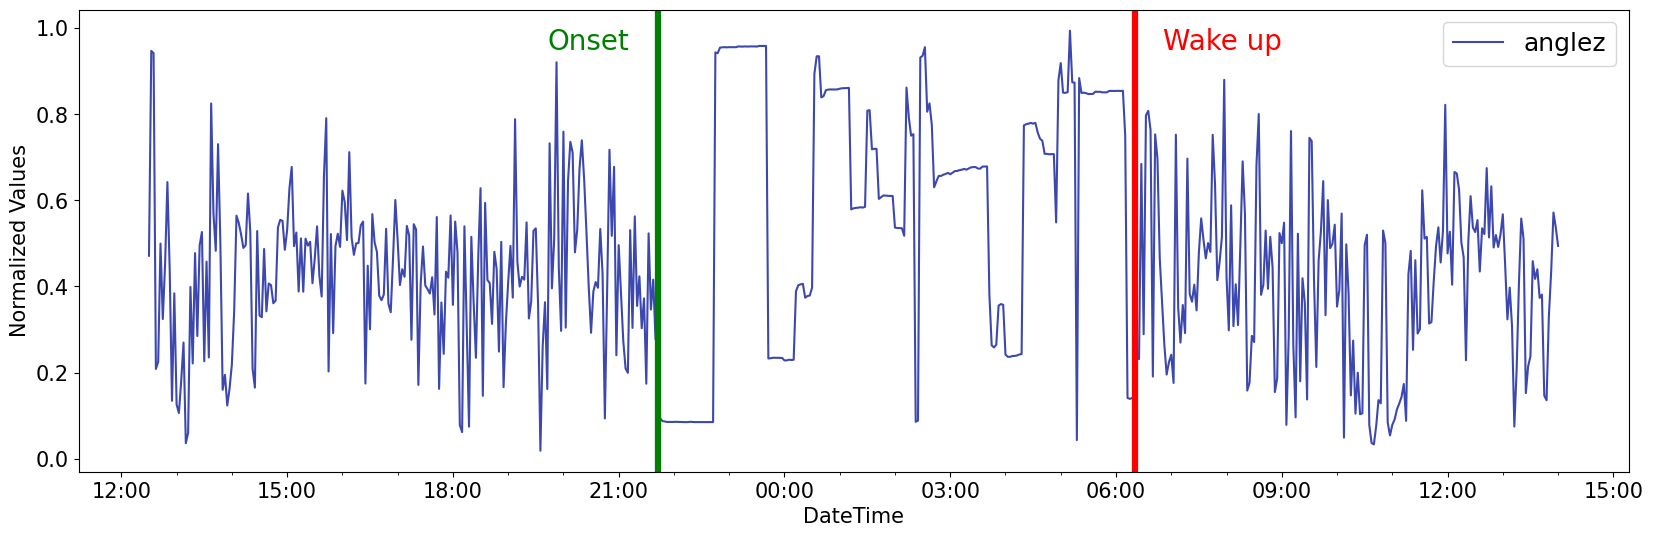

In [232]:
df5 = df4.iloc[::30]

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot()
ax.plot(df5['date_time'], df5['anglez_norm'], color='#3C48B0', linewidth=1.5, label="anglez")
#ax.plot(df5['date_time'], df5['enmo_norm'], color='#122740', linewidth=1.5, label="enmo")
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='r', linewidth=4.5)
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='g', linewidth=4.5)
#ax.plot(df_subset['date_time'], df_subset['event_wakeup'], color='r', label="wake-up")
#ax.plot(df_subset['date_time'], df_subset['event_onset'], color='g', label="onset")
#ax.legend()
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
labels = ax.get_xticklabels()
plt.xlabel("DateTime", fontsize=15)
plt.ylabel("Normalized Values", fontsize=15)
plt.legend(loc='upper right',fontsize=18)
plt.text(b.iloc[0]-timedelta(hours=2, minutes=0),0.95,'Onset',color='green',fontsize=20)
plt.text(a.iloc[0]+timedelta(hours=0.5, minutes=0),0.95,'Wake up',color='red',fontsize=20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

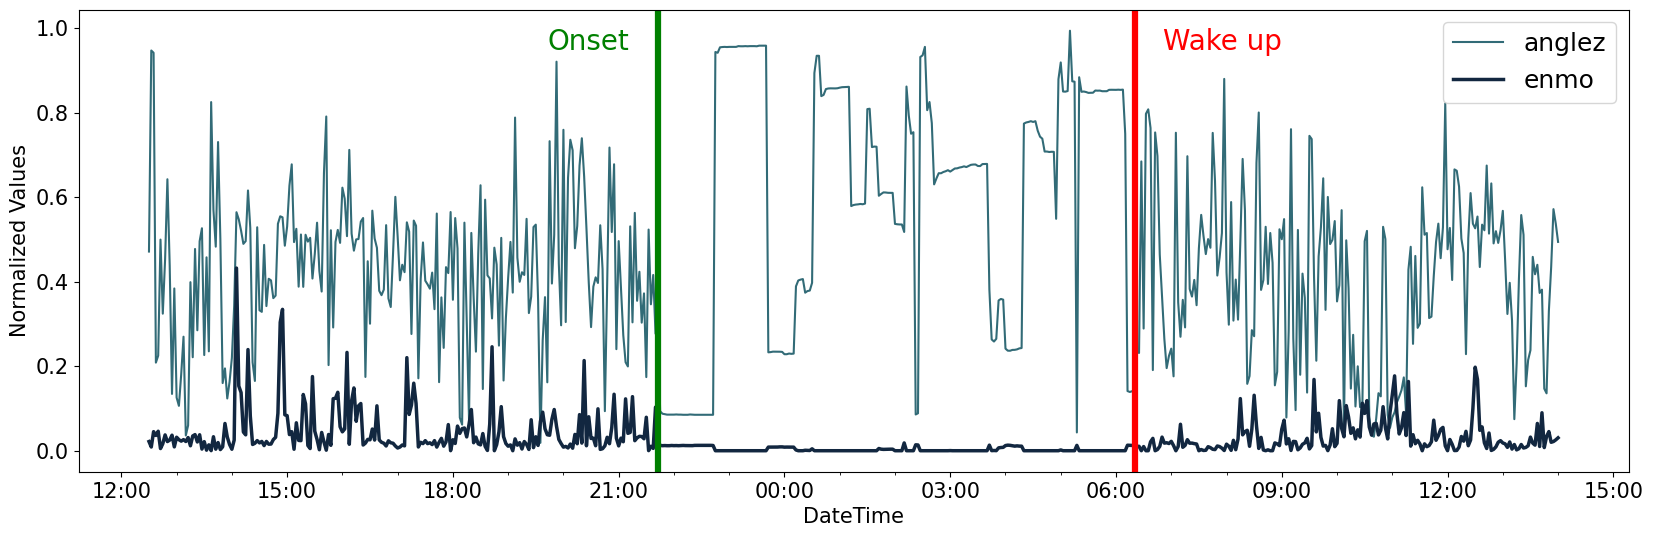

In [229]:
df5 = df4.iloc[::30]

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot()
ax.plot(df5['date_time'], df5['anglez_norm'], color='#326B77', linewidth=1.5, label="anglez")
ax.plot(df5['date_time'], df5['enmo_norm'], color='#122740', linewidth=2.5, label="enmo")
for i in range(0,len(a)):
    ax.axvline(x=a.iloc[i], color='r', linewidth=4.5)
for j in range(0,len(b)):
    ax.axvline(x=b.iloc[j], color='g', linewidth=4.5)
#ax.plot(df_subset['date_time'], df_subset['event_wakeup'], color='r', label="wake-up")
#ax.plot(df_subset['date_time'], df_subset['event_onset'], color='g', label="onset")
#ax.legend()
ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 3)))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
labels = ax.get_xticklabels()
plt.xlabel("DateTime", fontsize=15)
plt.ylabel("Normalized Values", fontsize=15)
plt.legend(loc='upper right',fontsize=18)
plt.text(b.iloc[0]-timedelta(hours=2, minutes=0),0.95,'Onset',color='green',fontsize=20)
plt.text(a.iloc[0]+timedelta(hours=0.5, minutes=0),0.95,'Wake up',color='red',fontsize=20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

# Reading test_series - use to get predictions and upload solution

In [ ]:
%%time
test_series = (pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

In [ ]:
%%time
# inspired by https://www.kaggle.com/code/renatoreggiani/reduce-memory-usage-zzzs-cmi
# with tweaks determined by the selected polars loading strategy
# tweaks inspired by https://github.com/softhints/Pandas-Tutorials/blob/master/column/3.check-dtype-column-columns-pandas-dataframe.ipynb
from pandas.api.types import is_datetime64_ns_dtype
def reduce_mem_usage(df):
    """ iterate through all numeric columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float16)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

train_series = reduce_mem_usage(train_series)

In [ ]:
%%time
test_series = reduce_mem_usage(test_series)

# remove the nights of which we don't have any event reported.
# also print a new train_series parquet and a new train_events parquet that excludes those nights


In [ ]:
train_series.groupby(['series_id'])['step'].size()

In [ ]:
train_events.groupby(['series_id'])['step'].size()

# Function to merge train series with train events to get the label and remove those nights without data

In [ ]:
def get_series_data(series_id):
    
    df=train_series[(train_series['series_id']==series_id)][['series_id', 'step', 'timestamp', 'anglez', 'enmo', 'year', 'month',
       'day', 'hour']]
    df['date_time'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    #df = df.drop('timestamp', axis=1)
    
    ev=train_events[(train_events['series_id']==series_id)][['series_id','night','event','step','timestamp']]
    ev = ev[ev['step'].notna()]
    ev['date_time'] = pd.to_datetime(ev['timestamp']).apply(lambda t: t.tz_localize(None))
    ev = ev.drop('timestamp', axis=1)
    
    df2 = pd.merge(df, ev, on='date_time', how='outer')
    
    del df
    del ev
    
    df2['step']=df2['step_x']
    df2['series_id']=df2['series_id_x']
    df2 = df2.drop(['series_id_x','series_id_y','step_x','step_y'], axis=1)
    df2['event_raw'] = df2['event']
    df2['event'] = df2['event'].fillna(0)

    # fill values for night feature
    df2['night'][0] = 1
    df2['night'] = df2['night'].interpolate()
    df2['night'] = round(df2['night'])
    # map numeric values to event feature
    df2.loc[df2['event']=='onset','event'] = -1
    df2.loc[df2['event']=='wakeup','event'] = 1
    
    df2['year_month_day']=df2['year'].astype(str) + df2['month'].astype(str).str.zfill(2)+ df2['day'].astype(str).str.zfill(2)

    df3=df2.groupby('night').year_month_day.nunique().reset_index()
    #df3=df3[(df3['year_month_day']<3)]
   
    df4 = pd.merge(df2, df3, on='night', how='inner')
    
    del df2
    del df3
    
    df4 = df4.drop(['year_month_day_x','year_month_day_y'], axis=1)
    
    df5=df4.groupby(['night'])['event'].nunique().reset_index()
    df5=df5[(df5['event']==3)]
    df6 = pd.merge(df4, df5[['night']], on='night', how='inner')
    
    del df4
    del df5
    
    df6['day'] = df6['day'].apply(str)
    df6['month'] = df6['month'].apply(str)
    df6['year_month_day']=df6['year'].astype(str) + df6['month'].astype(str)+ df6['day'].astype(str)
    
    if len(df6)>0:
        df7=df6.groupby(['year','month','day'])['event'].nunique().reset_index()
        df7['year_month_day']=df7['year'].astype(str) + df7['month'].astype(str)+ df7['day'].astype(str)
        df7=df7[(df7['event']>1)]
        df8 = pd.merge(df6, df7[['year_month_day']], on='year_month_day', how='inner')

        df8['event_2']=df8['event_raw']
        df8['event_2'].fillna('Other', inplace=True)

        df8['event']=df8['event_raw']
        df8['event'].fillna(method='ffill', inplace=True)
        df8['event'].fillna('wakeup', inplace=True)

        df8=df8[['series_id', 'step', 'timestamp', 'anglez', 'enmo','hour','event','event_2','night']]
    else: 
        df8=df6
        
    del df6
    #del df7
    
    return df8

# Generate new train series, and new train events

In [ ]:
len(train_series)

In [ ]:
train_series.columns

In [ ]:
series_id = train_series.series_id.unique()
len(series_id)
#series_id

In [ ]:
series_id2=['038441c925bb','03d92c9f6f8a']
series_id2

In [ ]:
%%time

import joblib

print("Number of jobs: ",int(cpu_count()))

train_series_new = []

#for idx in tqdm(series_id2):
for idx in tqdm(series_id): 

    test = get_series_data(idx)
    if len(test)>0:
        train_series_new.append(test)
        
    gc.collect()
    
#train_series_new

In [ ]:
joblib.dump((train_series_new), 'train_series_10112023.pkl')
len(train_series_new)

In [ ]:
train_series_new_df = pd.concat(train_series_new, ignore_index=True).reset_index(names='row_id')

train_series_new_df.astype('float32', errors='ignore').to_parquet('train_series_10112023.parquet',
                                                                  use_deprecated_int96_timestamps=True)

len(train_series_new_df)